Shared Memory
=============
In this part we are going to talk about shared memory and how we can use it to
improve performance.

0 In general
------------
Shared memory is a small portion of memory connected to each thread block, which
is controllable by the user. It is used to lessen the amount of reads and writes
to global memory as the latency is around 100 times lower. Also in cases where
you have many local variables, it can also be an advantage to use shared memory
as they could be pushed to global memory.

To use shared memory, you have to mark your variable with `__local`, like so
`__local int array[10][10];`. When using arrays it is also worth noting that
they can not be allocated with a dynamic size. This means that the size can not
come from a variable and must be written in as a part of the kernel code.

1 Matrix transposition
----------------------
In this section we will be looking at matrix transposition. It is a problem
where we will get problems with memory coalescing without using shared memory.
Our first implementation will just be the naïve one, where we will transpose
directly.

```c++
__kernel void matrixtranspose(
    __global const int *a,
    __global int *trA,
    ushort columnsA,
    ushort rowsA)
{
    int i = get_global_id(0);
    int j = get_global_id(1);

    trA[j*rowsA+i] = a[i*columnsA+j];
}
```

As we can see, we will not get a coalesced memory access when writing to global
memory.

In [1]:
import numpy as np
import pyopencl as cl
import time

# Getting context for running on the GPU
ctx = cl.create_some_context()
queue = cl.CommandQueue(ctx)

prg = cl.Program(ctx, """
        __kernel void matrixtranspose(
            __global const int *a,
            __global int *trA,
            ushort columnsA,
            ushort rowsA)
        {
            int i = get_global_id(0);
            int j = get_global_id(1);

            trA[j*rowsA+i] = a[i*columnsA+j];
        }
        """).build()

width = 10000
height = 10000

a = np.arange(height * width).astype(np.int32)
a.shape = (height, width)

trA = np.empty((width, height)).astype(np.int32)

mf = cl.mem_flags
a_dev = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=a)
trA_dev = cl.Buffer(ctx, mf.WRITE_ONLY, size=trA.nbytes)

start_time = time.time()
prg.matrixtranspose(
        queue,
        (height,width),
        None,
        a_dev,
        trA_dev,
        np.uint16(width),
        np.uint16(height))

cl.enqueue_copy(queue, trA, trA_dev).wait()
total_time_normal = time.time() - start_time

print(trA)

[[       0    10000    20000 ... 99970000 99980000 99990000]
 [       1    10001    20001 ... 99970001 99980001 99990001]
 [       2    10002    20002 ... 99970002 99980002 99990002]
 ...
 [    9997    19997    29997 ... 99979997 99989997 99999997]
 [    9998    19998    29998 ... 99979998 99989998 99999998]
 [    9999    19999    29999 ... 99979999 99989999 99999999]]


2 Shared Memory implementation
------------------------------
To get coalesced memory access, we will use shared memory. We will use the
shared memory to save the part of global memory, which is read by the thread
block. We can then use this saved to write to the correct place in another
thread so we get coalesced access.

To help us do this, we have to look closer at some features in OpenCL. Firstly
we need to understand barriers. A barrier is a way to make sure that all threads
are synchronised. It works by stopping threads continuing until all threads
within the thread block have reached the barrier. In OpenCL, we can use barriers
in two different scenarios by changing the argument when calling `barrier`
function. `CLK_LOCAL_MEM_FENCE` waits until shared memory has been flushed and
`CLK_GLOBAL_MEM_FENCE` waits until global memory has been flushed. It is also
important to note, that all code must pass the same barrier at the same time.
Using barriers in a different way will result in undefined behaviour.
![One thread is yet to reach the barrier, so the two others are waiting](barrier.png)
![All threads have reached the barrier, so they now can continue](barrierdone.png)

Two additional things we need are `get_local_id` and `get_group_id`. These two
functions works like `get_global_id`. `get_local_id` gets the current index in
the thread block, we are working in, and `get_group_id` gets the index of the
thread block. We need these to take advantage shared memory, because the entire
thread block needs to swap group id dimension 0 and 1, and then we can transpose
inside the thread block.
![Swapping two thread blocks in a small grid](threadblocks.png)

```c++
    #define T 16
    __kernel void matrixtranspose(
        __global const int *a,
        __global int *trA,
        ushort columnsA,
        ushort rowsA)
    {
        int i = get_global_id(0);
        int j = get_global_id(1);

        int loc_i = get_local_id(0);
        int loc_j = get_local_id(1);

        __local int tile[T][T];

        if (i < rowsA && j < columnsA) {
            tile[loc_j][loc_i] = a[i*columnsA+j];
        }

        barrier(CLK_LOCAL_MEM_FENCE);

        int group_i = get_group_id(0);
        int group_j = get_group_id(1);

        i = group_j*T+loc_i;
        j = group_i*T+loc_j;
        if (i < columnsA && j < rowsA) {
            trA[i*rowsA+j] =  tile[loc_i][loc_j];
        }
    }
```

In [2]:
import numpy as np
import pyopencl as cl
import math
import time

# Getting context for running on the GPU
ctx = cl.create_some_context()
queue = cl.CommandQueue(ctx)

width = 10000
height = 10000

dim_size = 32
grid_size = (dim_size * int(math.ceil(height/float(dim_size))),
             dim_size * int(math.ceil(width/float(dim_size))))

prg = cl.Program(ctx, """
            #define T """ + str(dim_size) + """
            __kernel void matrixtranspose(
                __global const int *a,
                __global int *trA,
                ushort columnsA,
                ushort rowsA)
            {
                int i = get_global_id(0);
                int j = get_global_id(1);

                int loc_i = get_local_id(0);
                int loc_j = get_local_id(1);

                __local int tile[T][T];

                if (i < rowsA && j < columnsA) {
                    tile[loc_j][loc_i] = a[i*columnsA+j];
                }

                barrier(CLK_LOCAL_MEM_FENCE);

                int group_i = get_group_id(0);
                int group_j = get_group_id(1);

                i = group_j*T+loc_i;
                j = group_i*T+loc_j;
                if (i < columnsA && j < rowsA) {
                    trA[i*rowsA+j] =  tile[loc_i][loc_j];
                }
            }
            """).build()

a = np.arange(height * width).astype(np.int32)
a.shape = (height, width)

trA = np.empty((width, height)).astype(np.int32)

mf = cl.mem_flags
a_dev = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=a)
trA_dev = cl.Buffer(ctx, mf.WRITE_ONLY, size=trA.nbytes)

start_time = time.time()
prg.matrixtranspose(
        queue,
        grid_size,
        (dim_size,dim_size),
        a_dev,
        trA_dev,
        np.uint16(width),
        np.uint16(height))

cl.enqueue_copy(queue, trA, trA_dev).wait()
total_time_shared = time.time() - start_time

print(trA)

[[       0    10000    20000 ... 99970000 99980000 99990000]
 [       1    10001    20001 ... 99970001 99980001 99990001]
 [       2    10002    20002 ... 99970002 99980002 99990002]
 ...
 [    9997    19997    29997 ... 99979997 99989997 99999997]
 [    9998    19998    29998 ... 99979998 99989998 99999998]
 [    9999    19999    29999 ... 99979999 99989999 99999999]]


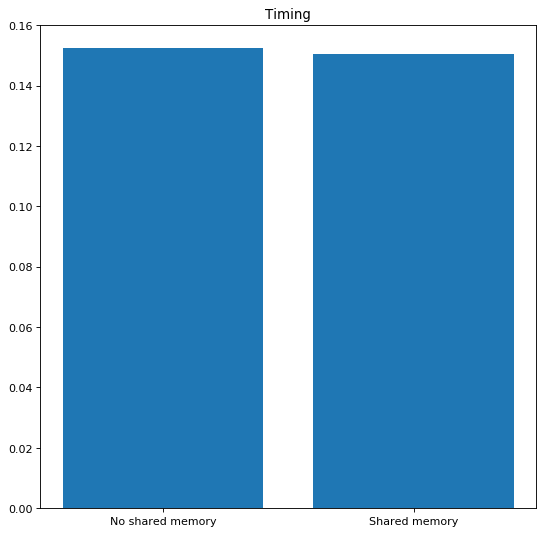

In [4]:
import matplotlib.pyplot as plt
names = ["No shared memory", "Shared memory"]
values = [total_time_normal, total_time_shared]

fig=plt.figure(figsize=(8, 8), dpi= 80, facecolor='w', edgecolor='k')
plt.title("Timing")
plt.bar(names, values)

plt.show()